# Keras integration

TODO: Some explanation...

In [1]:
import numpy as np
import tensorflow as tf
import gpflow
import gpflux
from gpflow.ci_utils import ci_niter

import matplotlib.pyplot as plt

In [2]:
tf.keras.backend.set_floatx("float64")

In [3]:
%matplotlib inline

In [4]:
d = np.load("../../tests/snelson1d.npz")
X, Y = d["X"], d["Y"]
num_data, input_dim = X.shape
_, output_dim = Y.shape

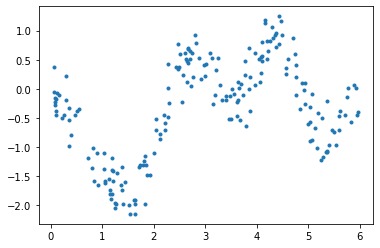

In [5]:
plt.figure()
plt.plot(X, Y, ".")
plt.show()

In [6]:
def create_layers():
    num_inducing = 13
    hidden_dim = 1
    Z = np.linspace(X.min() - 0.1, X.max() + 0.1, num_inducing).reshape(-1, 1)

    layer1 = gpflux.helpers.construct_gp_layer(
        num_data, num_inducing, input_dim, hidden_dim, z_init=Z.copy()
    )
    layer1.mean_function = gpflow.mean_functions.Identity()  # TODO: pass layer_type instead
    layer1.q_sqrt.assign(layer1.q_sqrt * 0.01)

    layer2 = gpflux.helpers.construct_gp_layer(
        num_data, num_inducing, hidden_dim, output_dim, z_init=Z.copy()
    )

    likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.01))

    return layer1, layer2, likelihood_layer

In [7]:
def create_model(model_class):
    """
    We pass in `model_class` to make it easy to use
    `gpflux.optimization.NatGradModel`, which is required for combining
    GPflow's `NaturalGradient` optimizer with Keras. `model_class` needs to be
    a constructor that has the same semantics as `tf.keras.Model.__init__`.
    """
    layer1, layer2, likelihood_layer = create_layers()
    dgp = gpflux.models.DeepGP([layer1, layer2], likelihood_layer, default_model_class=model_class)
    return dgp

In [8]:
batch_size = 2
num_epochs = ci_niter(200)

In [9]:
dgp = create_model(tf.keras.Model)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="loss",
        patience=5,
        factor=0.95,
        verbose=1,
        min_lr=1e-6,
    )
]

dgp_train = dgp.as_training_model()
dgp_train.compile(tf.optimizers.Adam(learning_rate=0.1))

history = dgp_train.fit(
    {"inputs": X, "targets": Y}, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks
)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Epoch 1/2


  1/100 [..............................] - ETA: 7:02 - loss: 68.0661 - gp_layer_prior_kl: 0.2668 - gp_layer_1_prior_kl: 0.0000e+00

 36/100 [=========>....................] - ETA: 0s - loss: 32.2982 - gp_layer_prior_kl: 0.0895 - gp_layer_1_prior_kl: 0.0802      

 71/100 [====================>.........] - ETA: 0s - loss: 21.8458 - gp_layer_prior_kl: 0.0777 - gp_layer_1_prior_kl: 0.1014

100/100 [==============================] - 4s 1ms/step - loss: 17.7071 - gp_layer_prior_kl: 0.0691 - gp_layer_1_prior_kl: 0.1054


Epoch 2/2
  1/100 [..............................] - ETA: 0s - loss: 0.3171 - gp_layer_prior_kl: 0.0420 - gp_layer_1_prior_kl: 0.1111

 37/100 [==========>...................] - ETA: 0s - loss: 1.5520 - gp_layer_prior_kl: 0.0413 - gp_layer_1_prior_kl: 0.1013

 72/100 [====================>.........] - ETA: 0s - loss: 1.4131 - gp_layer_prior_kl: 0.0372 - gp_layer_1_prior_kl: 0.0958

100/100 [==============================] - 0s 1ms/step - loss: 1.3415 - gp_layer_prior_kl: 0.0342 - gp_layer_1_prior_kl: 0.0928


In [10]:
dgp_natgrad = create_model(gpflux.optimization.NatGradModel)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="loss",
        patience=5,
        factor=0.95,
        verbose=1,
        min_lr=1e-6,
    )
]

dgp_natgrad_train = dgp_natgrad.as_training_model()
dgp_natgrad_train.compile(
    [
        gpflow.optimizers.NaturalGradient(gamma=0.05),
        gpflow.optimizers.NaturalGradient(gamma=0.05),
        tf.optimizers.Adam(learning_rate=0.1),
    ]
)

history_natgrad = dgp_natgrad_train.fit(
    {"inputs": X, "targets": Y}, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks
)

Epoch 1/2


Executing NatGradModel backwards pass


Executing NatGradModel backwards pass


  1/100 [..............................] - ETA: 6:20 - loss: 143.6326 - gp_layer_2_prior_kl: 0.2668 - gp_layer_3_prior_kl: 0.0000e+00

 33/100 [========>.....................] - ETA: 0s - loss: 36.4130 - gp_layer_2_prior_kl: 0.2667 - gp_layer_3_prior_kl: 0.0224       

 66/100 [==================>...........] - ETA: 0s - loss: 23.7922 - gp_layer_2_prior_kl: 0.2666 - gp_layer_3_prior_kl: 0.0285

 98/100 [============================>.] - ETA: 0s - loss: 18.4411 - gp_layer_2_prior_kl: 0.2665 - gp_layer_3_prior_kl: 0.0321

100/100 [==============================] - 4s 2ms/step - loss: 18.0824 - gp_layer_2_prior_kl: 0.2665 - gp_layer_3_prior_kl: 0.0323


Epoch 2/2
  1/100 [..............................] - ETA: 0s - loss: 5.2137 - gp_layer_2_prior_kl: 0.2661 - gp_layer_3_prior_kl: 0.0424

 36/100 [=========>....................] - ETA: 0s - loss: 1.6066 - gp_layer_2_prior_kl: 0.2660 - gp_layer_3_prior_kl: 0.0444

 68/100 [===================>..........] - ETA: 0s - loss: 1.4708 - gp_layer_2_prior_kl: 0.2659 - gp_layer_3_prior_kl: 0.0462

100/100 [==============================] - 0s 2ms/step - loss: 1.3789 - gp_layer_2_prior_kl: 0.2657 - gp_layer_3_prior_kl: 0.0475


In [11]:
dgp_test = dgp.as_prediction_model()
res = dgp_test(X)

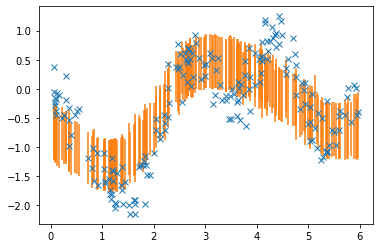

In [12]:
plt.plot(X, Y, "x")
plt.errorbar(X.squeeze(), np.squeeze(res.y_mean), np.sqrt(np.squeeze(res.y_var)), ls="")
plt.show()

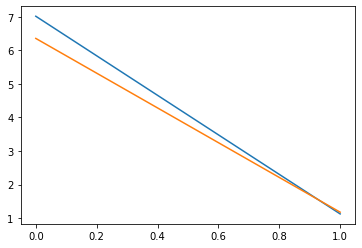

In [13]:
plt.plot(history.history["loss"], label="Adam")
plt.plot(history_natgrad.history["loss"], label="NatGrad")
plt.show()